# Setup

References: 1) https://medium.com/huggingface/how-to-build-a-state-of-the-art-conversational-ai-with-transfer-learning-2d818ac26313


2) https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh?usp=sharing#scrollTo=NKGBoVwuhM4H

3) https://towardsdatascience.com/teaching-gpt-2-a-sense-of-humor-fine-tuning-large-transformer-models-on-a-single-gpu-in-pytorch-59e8cec40912

In [ ]:
!pip install transformers

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [ ]:
# Function to first select topN tokens from the probability list and then based on the selected N word distribution
# get random token ID
def choose_from_top(probs, n=5):
    ind = np.argpartition(probs, -n)[-n:]
    top_prob = probs[ind]
    top_prob = top_prob / np.sum(top_prob) # Normalize
    choice = np.random.choice(n, 1, p = top_prob)
    token_id = ind[choice][0]
    return int(token_id)

In [ ]:
# load into a data frame
import json
filename = 'senticap_dataset.json'
data = json.load(open(filename, "r"))

In [ ]:
df = pd.DataFrame()
imageid = []
tokens = []
word_sentiment = []
sentiment = []
raw = []
split = []
filenames = []

for i in range(0,len(data['images'])):
    for j in range(0, len(data['images'][i]['sentences'])):
        imageid.append(data['images'][i]['imgid'])
        tokens.append(data['images'][i]['sentences'][j]['tokens'])
        word_sentiment.append(data['images'][i]['sentences'][j]['word_sentiment'])
        sentiment.append(data['images'][i]['sentences'][j]['sentiment'])
        raw.append(data['images'][i]['sentences'][j]['raw'])
        split.append(data['images'][i]['split'])
        filenames.append(data['images'][i]['filename'])

df['imageid'] = imageid
df['tokens'] = tokens
df['word_sentiment'] = word_sentiment
df['sentiment'] = sentiment
df['raw'] = raw
df['split'] = split
df['filenames'] = filenames

In [ ]:
filename = 'anp_list.txt'

with open(filename, 'r', encoding='cp1252') as f:
    lines = f.readlines()

anp = []

for i in range(0,len(lines)):
    anp.append(lines[i].rsplit(' ',1)[0])
  
anps = list(set(anp))

indexes = []
listofSent = []
adjs = []
listofTokens = []

for j in range(0,len(df)):
    indexes.append([i for i, e in enumerate(df['word_sentiment'][j]) if e == 1])
    listofSent.append([df['tokens'][j][i] for i in indexes[j]])
    adjs.append([i for i in listofSent[j] if i in anps])
    listofTokens.append([i for i in df['tokens'][j] if i not in adjs[j]])

df['adjs'] = adjs
df['tokensNotadjs'] = listofTokens

df

In [ ]:
import pickle
with open('senticap.pkl', 'wb') as f:
  pickle.dump(df, f)

In [ ]:
len(df)

8869

In [ ]:
len(df.imageid.unique())

2225

In [ ]:
df.dropna(inplace=True) #remove NA values
raw = df.raw.copy() #just use the main bio text in this example
raw

0       a plate of delicious food including French fries.
1       French fries are not a healthy food but it is ...
2       The plate has one of my favorite foods on it, ...
3              It was disgusting food, not just bad food.
4            A plate of disgusting food found at a diner.
                              ...                        
8864    A bedroom area with a bed lamp and a tall dirt...
8865    a large bed sitting next to an ugly wall with ...
8866        a towel that is on a rack in a dirty bathroom
8867    A dirty bathroom that has a dirty window made ...
8868            A dirty bathroom that has a window in it.
Name: raw, Length: 8869, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


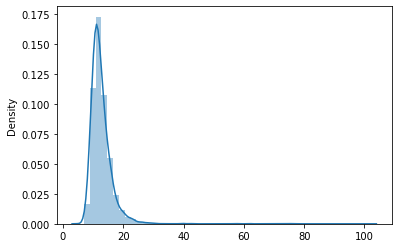

In [ ]:
doc_lengths = []

for r in raw:

    # get rough token count distribution
    tokens = nltk.word_tokenize(r)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [ ]:
np.max(doc_lengths)

102

# PyTorch Dataset & Dataloader

In [ ]:
from itertools import chain
new_tokens = list(set(list(chain(*df.tokens))))

In [ ]:
SPECIAL_TOKENS = ["<caption>", "<result>"] + new_tokens

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium', bos_token='<bos>', eos_token='<eos>', pad_token='<pad>', additional_special_tokens = SPECIAL_TOKENS) #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [ ]:
tokenizer.vocab_size

50257

In [ ]:
sentiments = df.adjs
captions = df.tokensNotadjs
resultWanted = df.tokens

In [ ]:
bos, eos, caption, result = "<bos>", "<eos>", "<caption>", "<result>"
#sequence = [[bos] + sentiments[1]] + [[caption] + captions[1]] + [[result] + resultWanted[1] + [eos]] 

In [ ]:
max_length=128
# Now we can pad reply and distractor inputs and targets to the same length
def pad(x, padding):
    return x + [padding] * (max_length - len(x))

# Finetune GPT2 Language Model

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, sentiments, captions, resultWanted, tokenizer, gpt2_type="gpt2", max_length=128):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []
    self.token_type_ids = []
    self.position_ids = []
    self.labels = []

    for i in range(0, len(sentiments)):
      sequence = [[bos] + sentiments[1]] + [[caption] + captions[1]] + [[result] + resultWanted[1] + [eos]]
      words = list(chain(*sequence))
      words = tokenizer.convert_tokens_to_ids(words)
      segments = [caption if i in [0,1] else result for i, s in enumerate(sequence) for _ in s]
      segments = tokenizer.convert_tokens_to_ids(segments)
      position = list(range(len(words)))
      attention = [1] * len(words)

      lm_targets = ([-1] * sum(len(s) for s in sequence[:-1])) + [-1] + tokenizer.convert_tokens_to_ids(sequence[-1][1:])
      last_token = len(words) - 1
      
      (words, segments) = [pad(x, tokenizer.convert_tokens_to_ids('<pad>')) for x in (words, segments)]
      lm_targets = pad(lm_targets, -1)
      attention = pad(attention, 0)
      
      # words token
      self.input_ids.append(torch.tensor(words, dtype=torch.long))
      # segment token
      self.token_type_ids.append(torch.tensor(segments, dtype=torch.long))
      # position token
      self.position_ids.append(torch.tensor(position, dtype=torch.long))
      # attention mask
      self.attn_masks.append(torch.tensor(attention, dtype=torch.long)) 
      # language modeling label
      self.labels.append(torch.tensor(lm_targets, dtype=torch.long))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.token_type_ids[idx], self.position_ids[idx], self.attn_masks[idx], self.labels[idx]

In [ ]:
dataset = GPT2Dataset(sentiments, captions, resultWanted, tokenizer, max_length=128)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,982 training samples
  887 validation samples


In [ ]:
batch_size = 2

In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
model.resize_token_embeddings(len(tokenizer))

Embedding(53530, 1024)

In [ ]:
BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 5e-4
WARMUP_STEPS = 200
MAX_SEQ_LEN = 128
total_steps = len(train_dataloader) * EPOCHS
from transformers import AdamW, get_linear_schedule_with_warmup

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [ ]:
model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps ,last_epoch = -1)
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0

models_folder = "trained_models"
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

for epoch in range(EPOCHS):
    
    print(f"EPOCH {epoch} started" + '=' * 30)
    
    for idx, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_token_type_ids = batch[1].to(device)
        b_position_ids = batch[2].to(device)
        b_masks = batch[3].to(device)
        b_labels = batch[4].to(device)
        
        outputs = model(input_ids=b_input_ids, 
                        attention_mask = b_masks, 
                        labels=b_input_ids)
        loss, logits = outputs[:2]                        
        loss.backward()
        sum_loss = sum_loss + loss.detach().data
                       
        proc_seq_count = proc_seq_count + 1
        if proc_seq_count == BATCH_SIZE:
            proc_seq_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()

        if batch_count == 100:
            print(f"sum loss {sum_loss}")
            batch_count = 0
            sum_loss = 0.0
    
    # Store the model after each epoch to compare the performance of them
    torch.save(model.state_dict(), os.path.join(models_folder, f"gpt2_medium_{epoch}.pt"))

EPOCH 0 started==============================
sum loss 898.6929321289062
sum loss 51.47236251831055
sum loss 17.49954605102539
sum loss 2.403780460357666
sum loss 0.32820817828178406
sum loss 0.36773279309272766
sum loss 1.5916633605957031
sum loss 0.08908189833164215
sum loss 0.060470033437013626
sum loss 0.034276917576789856
sum loss 0.030187247321009636
sum loss 0.12591131031513214
sum loss 0.1246960386633873
sum loss 0.012645425274968147
sum loss 0.022785553708672523
sum loss 0.007820970378816128
sum loss 0.02997579053044319
sum loss 0.021587330847978592
sum loss 0.03825334832072258
EPOCH 1 started==============================
sum loss 0.002597853308543563
sum loss 0.11651040613651276
sum loss 0.04950220137834549
sum loss 0.028491796925663948
sum loss 0.03410680592060089
sum loss 0.008645609021186829
sum loss 0.0022555883042514324
sum loss 0.0012999805621802807
sum loss 0.03342319279909134
sum loss 0.014898043125867844
sum loss 0.01154068298637867
sum loss 0.0008257759036496282
su

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'gpt2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# Display Model Info

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,9.89,5.19,0:08:43,0:00:10
2,5.75,3.56,0:08:43,0:00:10
3,3.32,2.11,0:08:43,0:00:10


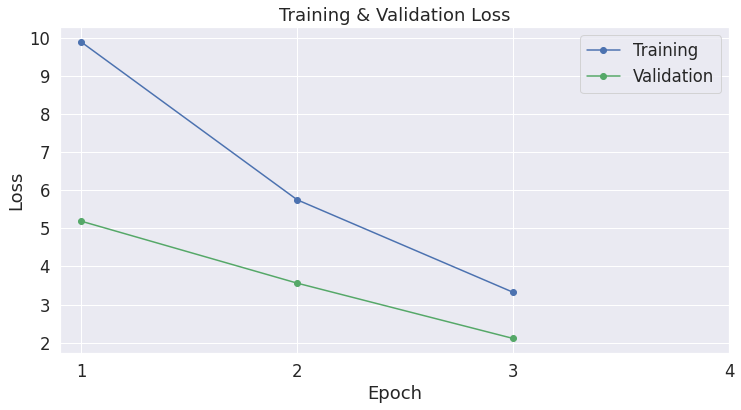

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (53530, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 509760K
-rw-r--r-- 1 root root     58K Nov 18 09:20 added_tokens.json
-rw-r--r-- 1 root root      1K Nov 18 09:20 config.json
-rw-r--r-- 1 root root    446K Nov 18 09:20 merges.txt
-rw-r--r-- 1 root root 508263K Nov 18 09:20 pytorch_model.bin
-rw-r--r-- 1 root root     50K Nov 18 09:20 special_tokens_map.json
-rw-r--r-- 1 root root     50K Nov 18 09:20 tokenizer_config.json
-rw-r--r-- 1 root root    878K Nov 18 09:20 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 497M Nov 18 09:20 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


# Generate Text

In [ ]:
model_save_name = 'gpt2.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

In [ ]:
for i in range(0,len(val_dataset)):
  val_dataset[i][0][torch.where(val_dataset[i][0] == 50261)[0]+1:torch.where(val_dataset[i][0] == 50258)[0]+1] = 50259

In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
MODEL_EPOCH = 2

models_folder = "trained_models"

model_path = os.path.join(models_folder, f"gpt2_medium_{MODEL_EPOCH}.pt")
model.load_state_dict(torch.load(model_path))

output_file_path = f'generated_{MODEL_EPOCH}.txt'

model.eval()
if os.path.exists(output_file_path):
    os.remove(output_file_path)

results = []
num = 0
with torch.no_grad():
   
        for idx, batch in enumerate(validation_dataloader):
        
            finished = False

            b_input_ids = batch[0].to(device)
            b_token_type_ids = batch[1].to(device)
            b_position_ids = batch[2].to(device)
            b_masks = batch[3].to(device)
            b_labels = batch[4].to(device)

            #cur_ids = batch[0].unsqueeze(0).to(device)
            cur_ids = torch.tensor(tokenizer.encode("<result>")).unsqueeze(0).long().to(device)

            for i in range(128):
                outputs = model(cur_ids,
                            labels=cur_ids)
                loss, logits = outputs[:2]
                softmax_logits = torch.softmax(logits[0,-1], dim=0) #Take the first(from only one in this case) batch and the last predicted embedding
                if i < 3:
                    n = 20
                else:
                    n = 3
                next_token_id = choose_from_top(softmax_logits.to('cpu').numpy(), n=n) #Randomly(from the topN probability distribution) select the next word
                cur_ids = torch.cat([cur_ids, torch.ones((1,1)).long().to(device) * next_token_id], dim = 1) # Add the last word to the running sequence

                if next_token_id in tokenizer.encode('<eos>'):
                    finished = True
                    break

            
            if finished:
                
                num = num + 1
                
                output_list = list(cur_ids.squeeze().to('cpu').numpy())
                output_text = tokenizer.decode(output_list)
                print(output_text)
                results.append(output_text)

Examples of generated sentences. Could not reproduce it due to time constraint.

In [ ]:
'''
<result> a great great great example of pizza and a drink i have liked my whole 

<result> a few zebras and a ostrich standing in a field <e 

<result> an awesome shot of a huge building <e 

<result> a man in glasses eating a large pizza off of the plate <e 

<result> a man standing in a kitchen next to a kitchen counter top <e 

<result> it is a photo of a man with his cell phone <e 

<result> a person who is taking a picture in a mirror <result> 

<result> the young boy sits in a parking lot on a surfboard in the ocean <result> 

<result> the girl sits in the chair to have a drink <e 

<result> a great great great <caption> 

<result> a man with a white helmet on is standing on a grassy area near trees <result> 

<result> a man with a white helmet on a skateboard as he skateboard down the middle of a concrete block <result> 

<result> nice new <caption>
'''